In [7]:
import requests
import json
import sqlite3

try:
    connection = sqlite3.connect('foods.db')
    cursor = connection.cursor()
#     cursor.execute('DROP DATABASE foods;')
    cursor.execute('''CREATE TABLE IF NOT EXISTS foods (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                name varchar(255) NOT NULL,
                delivery_name varchar(255),
                delivery_address varchar(255),
                delivery_phone varchar(255),
                delivery_url varchar(255),
                delivery_promotion varchar(255),
                delivery_openning varchar(255),
                delivery_rating float,
                type int,
                temperature_type int,
                humidity_type int);''')
    
    print('Successfully Connected to SQLite')
    connection.commit()
except sqlite3.Error as error:
    print("Failed to insert data into sqlite table", error)

# api search restaurant id by location
url_post_search_global = 'https://gappapi.deliverynow.vn/api/delivery/search_global'
body_params_search_global = {
    "category_group": 1,
    "city_id": 218,
    "delivery_only": True,
    "district_ids": [21],
    "foody_services": [1],
    "full_restaurant_ids": True,
    "keyword": "",
    "sort_type": 8
}

# api get delivery basic info
url_post_get_delivery_basic_info = 'https://gappapi.deliverynow.vn/api/delivery/get_infos'

# api get delivery detail info
# url_get_delivery_detail_info = 'https://gappapi.deliverynow.vn/api/delivery/get_detail?id_type=2&request_id=13631'

# api get dishes by delivery
# url_get_delivery_dishes = 'https://gappapi.deliverynow.vn/api/dish/get_delivery_dishes?id_type=2&request_id=13631'

headers = {
    'Content-Type': "application/x-www-form-urlencoded",
    'cache-control': "no-cache",
    'x-foody-access-token': '',
    'x-foody-api-version': '1',
    'x-foody-app-type': '1004',
    "x-foody-client-id": '',
    "x-foody-client-language": "vi",
    "x-foody-client-type": '1',
    "x-foody-client-version": "3.0.0"
}

# call api to search delivery
response_search_global = requests.post(url_post_search_global, headers=headers, json=body_params_search_global)
response_json = json.loads(response_search_global.text)
search_result = response_json.get('reply').get('search_result')
restaurant_ids = []
for sr in search_result:
    restaurant_ids.extend(sr.get('restaurant_ids'))
    
# chunk data to call api get foods
def chunker_list(seq, size):
    return (seq[i::size] for i in range(size))
delivery_list = list(chunker_list(restaurant_ids, 20))

Successfully Connected to SQLite


In [10]:
for dls in delivery_list:
    body_params_delivery_basic = {
        "restaurant_ids": dls
    }
    
    # call api get foods between array chunk
    response_delivery_basic = requests.post(
        url_post_get_delivery_basic_info,
        headers=headers,
        json=body_params_delivery_basic
    )
    response_delivery_json = json.loads(response_delivery_basic.text)
    delivery_infos = response_delivery_json.get('reply').get('delivery_infos')
    
    for index, delivery in enumerate(delivery_infos):
        connection = sqlite3.connect('foods.db')
        cursor = connection.cursor()
        
        # save foods to db
        sqlite_insert_with_param = """
                INSERT INTO foods(
                    name,
                    delivery_name,
                    delivery_address,
                    delivery_phone,
                    delivery_url,
                    delivery_promotion,
                    delivery_openning,
                    delivery_rating) 
                VALUES (?, ?, ?, ?, ?, ?, ?, ?);
            """
        opening_time = str(delivery.get('brand', {}).get('operating', {}).get('open_time', '')) + ' - ' + str(delivery.get('brand', {}).get('operating', {}).get('close_time', '')) + ' - ' + str(delivery.get('operating', {}).get('message', ''))
        promotion_text = ''
        for promotion in delivery.get('promotion_groups'):
            promotion_text += promotion.get('text')

        data_tuple = (
            delivery.get('name'),
            delivery.get('brand', {}).get('name', ''),
            delivery.get('address'),
            ', '.join(delivery.get('phones')),
            delivery.get('url'),
            promotion_text,
            opening_time,
            delivery.get('rating').get('avg')
        )
        cursor.execute(sqlite_insert_with_param, data_tuple)
        connection.commit()
        connection.close()

print('save success')

In [9]:
connection = sqlite3.connect('foods.db')
cursor = connection.cursor()
cursor.execute("SELECT * FROM foods")
rows = cursor.fetchall()
index = 0
for row in rows:
    index += 1
    print(index, row)

connection.close()

1 (1, 'Gà Rán & Gà Ủ Muối Hoa Tiêu - Hoàng Ngân', 'Gà Rán & Gà Ủ Muối Hoa Tiêu', '24 Ngõ 80 Hoàng Ngân, Cầu Giấy, Hà Nội', '0348470321', 'https://shopeefood.vn/ha-noi/ga-ran-ga-u-muoi-hoa-tieu-hoang-ngan', 'Giảm mónMã giảm 40k', '00:00:01 - 23:59:59 - ', 4.8, None, None, None)
2 (2, 'Trà Sữa Mixue - Dương Quảng Hàm', 'Trà Sữa Mixue', '71 Dương Quảng Hàm, Cầu Giấy, Hà Nội', '0336268071', 'https://shopeefood.vn/ha-noi/tra-sua-mixue-duong-quang-ham', 'Mã giảm 70k', '00:00:01 - 23:59:59 - ', 4.9, None, None, None)
3 (3, 'Royaltea - Ngõ 181 Xuân Thủy', 'Royaltea HongKong - Hà Nội', '9C Ngõ 181 Xuân Thủy, Cầu Giấy, Hà Nội', '0922886226', 'https://shopeefood.vn/ha-noi/royaltea-ngo-181-xuan-thuy', 'Giảm hết 50%Mã giảm 70k', '00:00:01 - 23:59:59 - ', 4.6, None, None, None)
4 (4, 'Hắt 2 Ô - Nem Nướng Nha Trang - Phan Văn Trường', 'Hắt 2 Ô - Nem Nướng Nha Trang', '1 N5 Ngõ 9 Phan Văn Trường, Cầu Giấy, Hà Nội', '0981936691', 'https://shopeefood.vn/ha-noi/hat-2-o-nem-nuong-nha-trang-che-tao-pho-pha

ValueError: shape mismatch: objects cannot be broadcast to a single shape

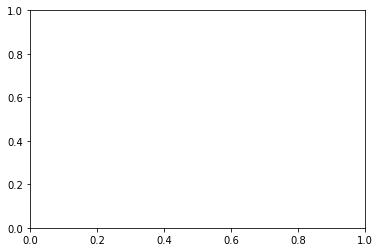

In [7]:
import pandas
import matplotlib.pyplot as plt

connection = sqlite3.connect('foods.db')
query = "SELECT * FROM foods"

data = pandas.read_sql(query, connection)
connection.close()

# print(data.groupby(['delivery_rating']).size())
fig, ax = plt.subplots()
new_set = data.groupby('delivery_rating').size()
width = 0.8
ax.bar([1,2,3,4,5], new_set, width=width)
plt.ylabel('Total')
plt.title('Number of sensor readings per outcome')
plt.xticks([1 + width/2, 2+ width/2,3+ width/2],('OK', 'FAIL', 'No read'))

plt.tight_layout()